# 1. Low

## 0. Set paths

In [1]:
# Variables
## Outdir
outDir = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/DPCL/speed_benchmark/low_simulation/'
import os
if not os.path.exists(outDir):
    os.makedirs(outDir)
## Temp
tmpDir = '/scratch/leuven/313/vsc31305/'
## Path to fragments
fragments_dict = {'DPLC': '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/DPCL/speed_benchmark/data/low/atac/fragments.tsv'}

## 1. QC

In [3]:
# Get TSS annotations
import pybiomart as pbm
# For mouse (mm39)
#dataset = pbm.Dataset(name='mmusculus_gene_ensembl',  host='http://www.ensembl.org')
# For mouse (mm10)
#dataset = pbm.Dataset(name='mmusculus_gene_ensembl',  host='http://nov2020.archive.ensembl.org/')
# For human (hg38)
dataset = pbm.Dataset(name='hsapiens_gene_ensembl',  host='http://www.ensembl.org')
# For human (hg19)
#dataset = pbm.Dataset(name='hsapiens_gene_ensembl',  host='http://grch37.ensembl.org/')
# For fly (dm6)
# dataset = pbm.Dataset(name='dmelanogaster_gene_ensembl',  host='http://www.ensembl.org')
annot = dataset.query(attributes=['chromosome_name', 'transcription_start_site', 'strand', 'external_gene_name', 'transcript_biotype'])
annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].astype('str')
filter = annot['Chromosome/scaffold name'].str.contains('CHR|GL|JH|MT')
annot = annot[~filter]
annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].str.replace(r'(\b\S)', r'chr\1')
annot.columns=['Chromosome', 'Start', 'Strand', 'Gene', 'Transcript_type']
annot = annot[annot.Transcript_type == 'protein_coding']

/local_scratch/tmp-vsc31305/ipykernel_14508/2601143857.py:17: FutureWarning: The default value of regex will change from True to False in a future version.
  annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].str.replace(r'(\b\S)', r'chr\1')


In [4]:
from pycisTopic.qc import *
path_to_regions = {'DPLC':'/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/DPCL/data/MACS_ATAC/iterative/peak_filtering_norm/combined_summits_final.bed'}
metadata_bc, profile_data_dict = compute_qc_stats(fragments_dict = fragments_dict,
                tss_annotation = annot,
                stats=['barcode_rank_plot', 'duplicate_rate', 'insert_size_distribution', 'profile_tss', 'frip'],
                label_list = None,
                path_to_regions = path_to_regions,
                n_cpu = 1,
                valid_bc = None,
                n_frag = 100,
                n_bc = None,
                tss_flank_window = 1000,
                tss_window = 50,
                tss_minimum_signal_window = 100,
                tss_rolling_window = 10,
                remove_duplicates = True,
                _temp_dir = tmpDir + 'ray_spill')

2022-11-07 15:13:41,673 cisTopic     INFO     Reading DPLC
2022-11-07 15:14:26,235 cisTopic     INFO     Computing barcode rank plot for DPLC
2022-11-07 15:14:26,238 cisTopic     INFO     Counting fragments
2022-11-07 15:14:28,501 cisTopic     INFO     Marking barcodes with more than 100
2022-11-07 15:14:28,506 cisTopic     INFO     Returning plot data
2022-11-07 15:14:28,508 cisTopic     INFO     Returning valid barcodes
2022-11-07 15:14:32,325 cisTopic     INFO     Computing duplicate rate plot for DPLC
2022-11-07 15:14:35,403 cisTopic     INFO     Return plot data
2022-11-07 15:14:35,516 cisTopic     INFO     Computing insert size distribution for DPLC
2022-11-07 15:14:35,518 cisTopic     INFO     Counting fragments
2022-11-07 15:14:37,348 cisTopic     INFO     Returning plot data
2022-11-07 15:15:14,828 cisTopic     INFO     Computing TSS profile for DPLC
2022-11-07 15:15:17,762 cisTopic     INFO     Formatting annnotation
2022-11-07 15:15:17,835 cisTopic     INFO     Creating cove

In [5]:
os.makedirs(outDir+'quality_control')
import pickle 
with open(outDir + 'quality_control/metadata_bc.pkl', 'wb') as f:
  pickle.dump(metadata_bc, f)

In [6]:
import pickle 
with open(outDir + 'quality_control/profile_data_dict.pkl', 'wb') as f:
  pickle.dump(profile_data_dict, f)

/opt/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


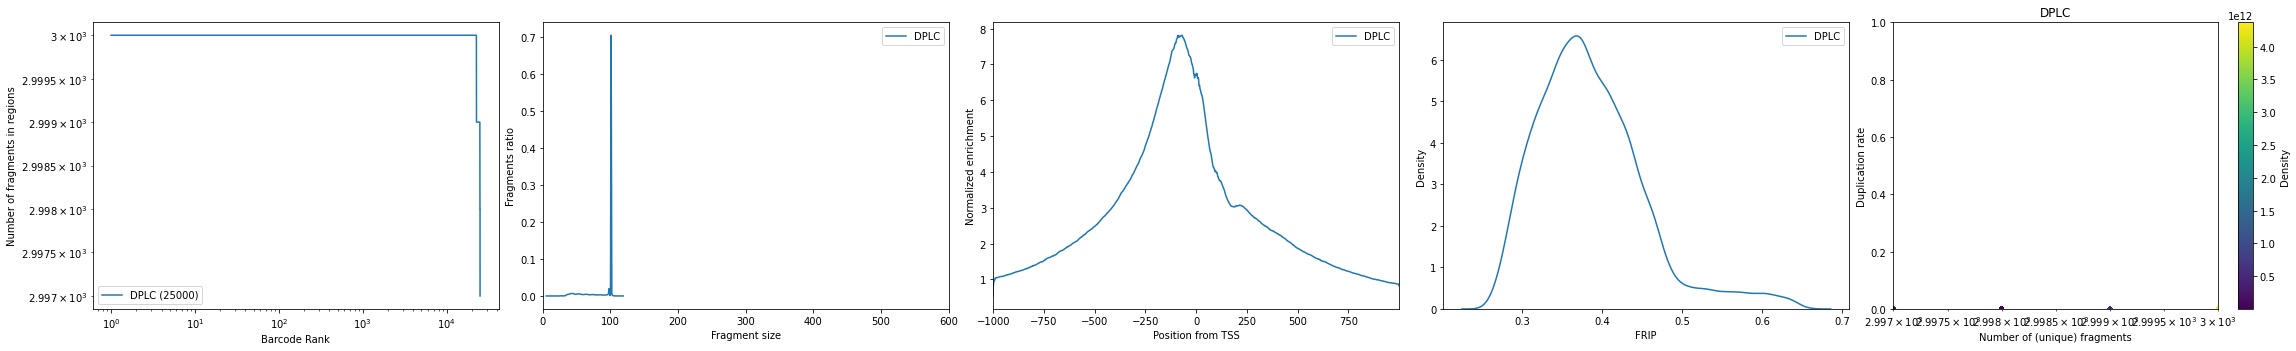

In [7]:
from pycisTopic.qc import *
plot_sample_metrics(profile_data_dict,
           insert_size_distriubtion_xlim=[0,600],
           ncol=5,
           plot=True,
           save= outDir + 'quality_control/sample_metrics.pdf')

In [8]:
# Return figure to plot together with other metrics, and cells passing filters. Figure will be saved as pdf.
from pycisTopic.qc import *
FRIP_NR_FRAG_fig, FRIP_NR_FRAG_filter=plot_barcode_metrics(metadata_bc['DPLC'],
                                       var_x='Log_unique_nr_frag',
                                       var_y='FRIP',
                                       min_x=3.5,
                                       max_x=None,
                                       min_y=0.2,
                                       max_y=None,
                                       return_cells=True,
                                       return_fig=True,
                                       plot=False,
                                       save= outDir + 'quality_control/barcode_metrics_FRIP-VS-NRFRAG.pdf')
# Return figure to plot together with other metrics, and cells passing filters
TSS_NR_FRAG_fig, TSS_NR_FRAG_filter=plot_barcode_metrics(metadata_bc['DPLC'],
                                      var_x='Log_unique_nr_frag',
                                      var_y='TSS_enrichment',
                                      min_x=3.5,
                                      max_x=None,
                                      min_y=4,
                                      max_y=None,
                                      return_cells=True,
                                      return_fig=True,
                                      plot=False,
                                      save= outDir + 'quality_control/barcode_metrics_TSS-VS-NRFRAG.pdf')
# Return figure to plot together with other metrics, but not returning cells (no filter applied for the duplication rate  per barcode)
DR_NR_FRAG_fig=plot_barcode_metrics(metadata_bc['DPLC'],
                                      var_x='Log_unique_nr_frag',
                                      var_y='Dupl_rate',
                                      min_x=3.5,
                                      max_x=None,
                                      min_y=None,
                                      max_y=None,
                                      return_cells=False,
                                      return_fig=True,
                                      plot=False,
                                      plot_as_hexbin = True)

/opt/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/venv/lib/python3.8/site-packages/seaborn/distributions.py:1689: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)
/opt/venv/lib/python3.8/site-packages/seaborn/distribut

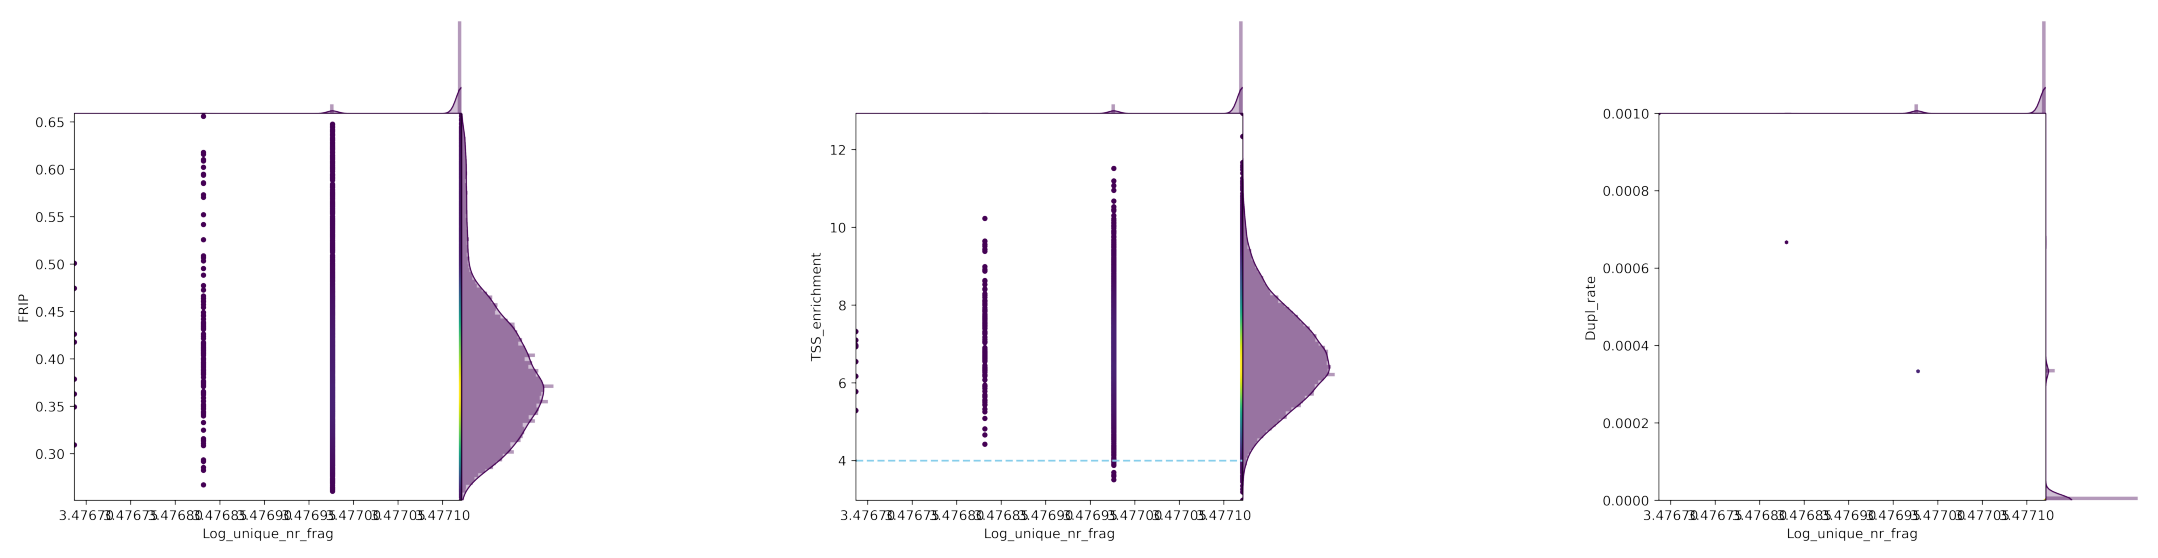

In [9]:
# Plot barcode stats in one figure
fig=plt.figure(figsize=(40,10))
plt.subplot(1, 3, 1)
img = fig2img(FRIP_NR_FRAG_fig) #To convert figures to png to plot together, see .utils.py. This converts the figure to png.
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 2)
img = fig2img(TSS_NR_FRAG_fig)
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 3)
img = fig2img(DR_NR_FRAG_fig)
plt.imshow(img)
plt.axis('off')
plt.show()

## 2. Create cisTopic object

In [2]:
# Path to regions
path_to_regions = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/DPCL/data/MACS_ATAC/iterative/peak_filtering_norm/combined_summits_final.bed'
# Blacklist
path_to_blacklist = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/pycisTopic/blacklist/hg38-blacklist.v2.bed'
# Metrics
import pickle
infile = open(outDir + 'quality_control/metadata_bc.pkl', 'rb')
metadata_bc = pickle.load(infile)
infile.close()
#Create objects
from pycisTopic.cistopic_class import *
cistopic_obj_list=[create_cistopic_object_from_fragments(path_to_fragments=fragments_dict[key],
                                               path_to_regions=path_to_regions,
                                               path_to_blacklist=path_to_blacklist,
                                               metrics=metadata_bc[key],
                                               valid_bc=None,
                                               n_cpu=1,
                                               project=key) for key in fragments_dict.keys()]

2022-11-07 15:37:24,996 cisTopic     INFO     Reading data for DPLC
2022-11-07 15:37:54,702 cisTopic     INFO     metrics provided!
2022-11-07 15:37:58,820 cisTopic     INFO     Counting fragments in regions
2022-11-07 15:38:38,366 cisTopic     INFO     Creating fragment matrix


/opt/venv/lib/python3.8/site-packages/pandas/core/reshape/reshape.py:134: PerformanceWarning: The following operation may generate 16073550000 cells in the resulting pandas object.
  warnings.warn(


2022-11-07 15:52:18,936 cisTopic     INFO     Converting fragment matrix to sparse matrix
2022-11-07 15:58:47,427 cisTopic     INFO     Removing blacklisted regions
2022-11-07 15:58:50,252 cisTopic     INFO     Creating CistopicObject
2022-11-07 15:58:53,492 cisTopic     INFO     Done!


In [3]:
cistopic_obj = cistopic_obj_list[0]
print(cistopic_obj)

CistopicObject from project DPLC with n_cells × n_regions = 25000 × 642942


In [4]:
# Save
with open(outDir + 'DPCL_cisTopicObject_3K_fragments_25K_cells.pkl', 'wb') as f:
  pickle.dump(cistopic_obj, f)

In [4]:
# Load cisTopic object
import pickle
infile = open('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/DPCL/speed_benchmark/high_simulation/DPCL_cisTopicObject_20K_fragments_25K_cells.pkl', 'rb')
cistopic_obj = pickle.load(infile)
infile.close()

# Save count matrix
import pandas as pd
count_matrix = pd.DataFrame.sparse.from_spmatrix(cistopic_obj.fragment_matrix, columns=cistopic_obj.cell_names, index=cistopic_obj.region_names)
count_matrix = count_matrix.sparse.to_dense()
count_matrix.insert(0, 'index', cistopic_obj.region_names)
import pyarrow.feather as feather
feather.write_feather(count_matrix, '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/DPCL/speed_benchmark/high_simulation/fragment_matrix.feather')

In [3]:
# Load cisTopic object
import pickle
infile = open('/staging/leuven/stg_00002/lcb/saibar/Projects/PanCancer/1_runs_separateCancers/MMlines_1_sc/pycistopic_output/cell_data.pkl', 'rb')
cell_data = pickle.load(infile)
infile.close()
cell_data.to_csv('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/archr_signac_comparison/melanoma/cell_info.tsv', sep='\t')

In [1]:
# Load cisTopic object
import pickle
infile = open('/staging/leuven/stg_00002/lcb/saibar/Projects/PanCancer/1_runs_separateCancers/MMlines_1_sc/pycistopic_output/cisTopicObject_2_noDBL_wModel_30topics.pkl', 'rb')
cistopic_obj = pickle.load(infile)
infile.close()

# Save count matrix
import pandas as pd
count_matrix = pd.DataFrame.sparse.from_spmatrix(cistopic_obj.fragment_matrix, columns=cistopic_obj.cell_names, index=cistopic_obj.region_names)
count_matrix = count_matrix.sparse.to_dense()
count_matrix.insert(0, 'index', cistopic_obj.region_names)
import pyarrow.feather as feather
feather.write_feather(count_matrix, '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/archr_signac_comparison/melanoma/fragment_matrix.feather')

/local_scratch/tmp-vsc31305/ipykernel_14757/910612806.py:4: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  cistopic_obj = pickle.load(infile)


In [5]:
# Save count matrix
import pandas as pd
count_matrix = pd.DataFrame.sparse.from_spmatrix(cistopic_obj.fragment_matrix, columns=cistopic_obj.cell_names, index=cistopic_obj.region_names)
count_matrix = count_matrix.sparse.to_dense()
count_matrix.insert(0, 'index', cistopic_obj.region_names)
import pyarrow.feather as feather
feather.write_feather(count_matrix, '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/DPCL/speed_benchmark/medium_simulation/fragment_matrix.feather')

MemoryError: Unable to allocate 59.9 GiB for an array with shape (25000, 642942) and data type int32

In [3]:
import pandas as pd
X = pd.DataFrame(cistopic_obj.fragment_matrix.todense(), index=cistopic_obj.region_names, columns=cistopic_obj.cell_names)
X.to_csv('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/DPCL/speed_benchmark/high_simulation/fragment_matrix.tsv', sep='\t')

MemoryError: Unable to allocate 59.9 GiB for an array with shape (642942, 25000) and data type int32

In [15]:
X.to_csv('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/DPCL/speed_benchmark/low_simulation/fragment_matrix.tsv', sep='\t')

In [15]:
cell_names = [y + '_' + str(x) for y in ['GM12878', 'HCT116', 'HepG2', 'IMR90', 'K562', 'MCF7', 'PC3', 'Panc1'] for x in range(1,1251)]
len(cell_names)

10000

In [16]:
cistopic_obj.subset(cells=cell_names)

In [17]:
print(cistopic_obj)

CistopicObject from project DPLC with n_cells × n_regions = 10000 × 640762


In [18]:
# Save
with open(outDir + 'DPCL_cisTopicObject_3K_fragments_10K_cells.pkl', 'wb') as f:
  pickle.dump(cistopic_obj, f)

In [19]:
cell_names = [y + '_' + str(x) for y in ['GM12878', 'HCT116', 'HepG2', 'IMR90', 'K562', 'MCF7', 'PC3', 'Panc1'] for x in range(1,126)]
len(cell_names)
cistopic_obj.subset(cells=cell_names)
print(cistopic_obj)

CistopicObject from project DPLC with n_cells × n_regions = 1000 × 428040


In [20]:
# Save
with open(outDir + 'DPCL_cisTopicObject_3K_fragments_1K_cells.pkl', 'wb') as f:
  pickle.dump(cistopic_obj, f)

In [21]:
cell_names = [y + '_' + str(x) for y in ['GM12878', 'HCT116', 'HepG2', 'IMR90', 'K562', 'MCF7', 'PC3', 'Panc1'] for x in range(1,11)]
len(cell_names)
cistopic_obj.subset(cells=cell_names)
print(cistopic_obj)

CistopicObject from project DPLC with n_cells × n_regions = 80 × 89724


In [22]:
# Save
with open(outDir + 'DPCL_cisTopicObject_3K_fragments_80_cells.pkl', 'wb') as f:
  pickle.dump(cistopic_obj, f)

# 2. Medium

## 0. Set paths

In [23]:
# Variables
## Outdir
outDir = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/DPCL/speed_benchmark/medium_simulation/'
import os
if not os.path.exists(outDir):
    os.makedirs(outDir)
## Temp
tmpDir = '/scratch/leuven/313/vsc31305/'
## Path to fragments
fragments_dict = {'DPLC': '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/DPCL/speed_benchmark/data/medium/atac/fragments.tsv'}

## 1. QC

In [24]:
# Get TSS annotations
import pybiomart as pbm
# For mouse (mm39)
#dataset = pbm.Dataset(name='mmusculus_gene_ensembl',  host='http://www.ensembl.org')
# For mouse (mm10)
#dataset = pbm.Dataset(name='mmusculus_gene_ensembl',  host='http://nov2020.archive.ensembl.org/')
# For human (hg38)
dataset = pbm.Dataset(name='hsapiens_gene_ensembl',  host='http://www.ensembl.org')
# For human (hg19)
#dataset = pbm.Dataset(name='hsapiens_gene_ensembl',  host='http://grch37.ensembl.org/')
# For fly (dm6)
# dataset = pbm.Dataset(name='dmelanogaster_gene_ensembl',  host='http://www.ensembl.org')
annot = dataset.query(attributes=['chromosome_name', 'transcription_start_site', 'strand', 'external_gene_name', 'transcript_biotype'])
annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].astype('str')
filter = annot['Chromosome/scaffold name'].str.contains('CHR|GL|JH|MT')
annot = annot[~filter]
annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].str.replace(r'(\b\S)', r'chr\1')
annot.columns=['Chromosome', 'Start', 'Strand', 'Gene', 'Transcript_type']
annot = annot[annot.Transcript_type == 'protein_coding']

/local_scratch/tmp-vsc31305/ipykernel_29089/2601143857.py:17: FutureWarning: The default value of regex will change from True to False in a future version.
  annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].str.replace(r'(\b\S)', r'chr\1')


In [25]:
from pycisTopic.qc import *
path_to_regions = {'DPLC':'/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/DPCL/data/MACS_ATAC/iterative/peak_filtering_norm/combined_summits_final.bed'}
metadata_bc, profile_data_dict = compute_qc_stats(fragments_dict = fragments_dict,
                tss_annotation = annot,
                stats=['barcode_rank_plot', 'duplicate_rate', 'insert_size_distribution', 'profile_tss', 'frip'],
                label_list = None,
                path_to_regions = path_to_regions,
                n_cpu = 1,
                valid_bc = None,
                n_frag = 100,
                n_bc = None,
                tss_flank_window = 1000,
                tss_window = 50,
                tss_minimum_signal_window = 100,
                tss_rolling_window = 10,
                remove_duplicates = True,
                _temp_dir = tmpDir + 'ray_spill')

2022-11-07 16:20:25,497 cisTopic     INFO     Reading DPLC
2022-11-07 16:22:32,638 cisTopic     INFO     Computing barcode rank plot for DPLC
2022-11-07 16:22:32,642 cisTopic     INFO     Counting fragments
2022-11-07 16:22:40,239 cisTopic     INFO     Marking barcodes with more than 100
2022-11-07 16:22:40,245 cisTopic     INFO     Returning plot data
2022-11-07 16:22:40,247 cisTopic     INFO     Returning valid barcodes
2022-11-07 16:22:53,366 cisTopic     INFO     Computing duplicate rate plot for DPLC
2022-11-07 16:23:03,441 cisTopic     INFO     Return plot data
2022-11-07 16:23:03,613 cisTopic     INFO     Computing insert size distribution for DPLC
2022-11-07 16:23:03,615 cisTopic     INFO     Counting fragments
2022-11-07 16:23:10,060 cisTopic     INFO     Returning plot data
2022-11-07 16:24:56,402 cisTopic     INFO     Computing TSS profile for DPLC
2022-11-07 16:25:06,093 cisTopic     INFO     Formatting annnotation
2022-11-07 16:25:06,161 cisTopic     INFO     Creating cove

In [26]:
os.makedirs(outDir+'quality_control')
import pickle 
with open(outDir + 'quality_control/metadata_bc.pkl', 'wb') as f:
  pickle.dump(metadata_bc, f)

In [27]:
import pickle 
with open(outDir + 'quality_control/profile_data_dict.pkl', 'wb') as f:
  pickle.dump(profile_data_dict, f)

/opt/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


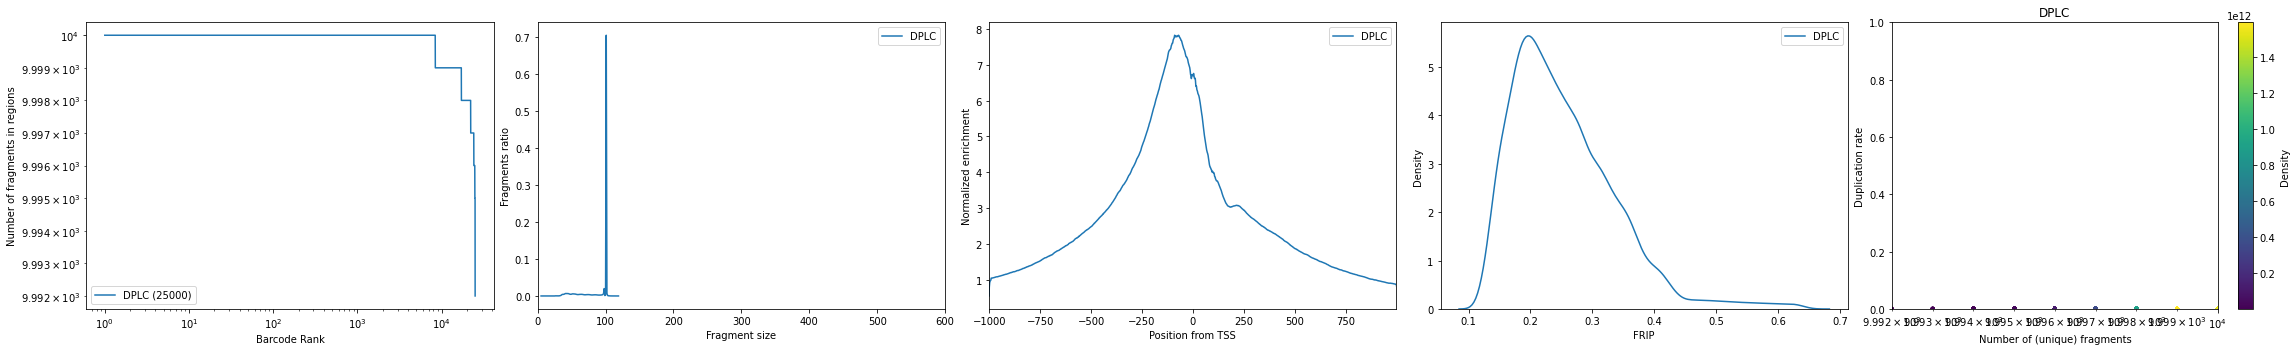

In [28]:
from pycisTopic.qc import *
plot_sample_metrics(profile_data_dict,
           insert_size_distriubtion_xlim=[0,600],
           ncol=5,
           plot=True,
           save= outDir + 'quality_control/sample_metrics.pdf')

In [30]:
# Return figure to plot together with other metrics, and cells passing filters. Figure will be saved as pdf.
from pycisTopic.qc import *
FRIP_NR_FRAG_fig, FRIP_NR_FRAG_filter=plot_barcode_metrics(metadata_bc['DPLC'],
                                       var_x='Log_unique_nr_frag',
                                       var_y='FRIP',
                                       min_x=3.5,
                                       max_x=None,
                                       min_y=0.2,
                                       max_y=None,
                                       return_cells=True,
                                       return_fig=True,
                                       plot=False,
                                       save= outDir + 'quality_control/barcode_metrics_FRIP-VS-NRFRAG.pdf')
# Return figure to plot together with other metrics, and cells passing filters
TSS_NR_FRAG_fig, TSS_NR_FRAG_filter=plot_barcode_metrics(metadata_bc['DPLC'],
                                      var_x='Log_unique_nr_frag',
                                      var_y='TSS_enrichment',
                                      min_x=3.5,
                                      max_x=None,
                                      min_y=4,
                                      max_y=None,
                                      return_cells=True,
                                      return_fig=True,
                                      plot=False,
                                      save= outDir + 'quality_control/barcode_metrics_TSS-VS-NRFRAG.pdf')
# Return figure to plot together with other metrics, but not returning cells (no filter applied for the duplication rate  per barcode)
DR_NR_FRAG_fig=plot_barcode_metrics(metadata_bc['DPLC'],
                                      var_x='Log_unique_nr_frag',
                                      var_y='Dupl_rate',
                                      min_x=3.5,
                                      max_x=None,
                                      min_y=None,
                                      max_y=None,
                                      return_cells=False,
                                      return_fig=True,
                                      plot=False,
                                      plot_as_hexbin = True)

/opt/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/venv/lib/python3.8/site-packages/seaborn/distributions.py:1689: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)
/opt/venv/lib/python3.8/site-packages/seaborn/distribut

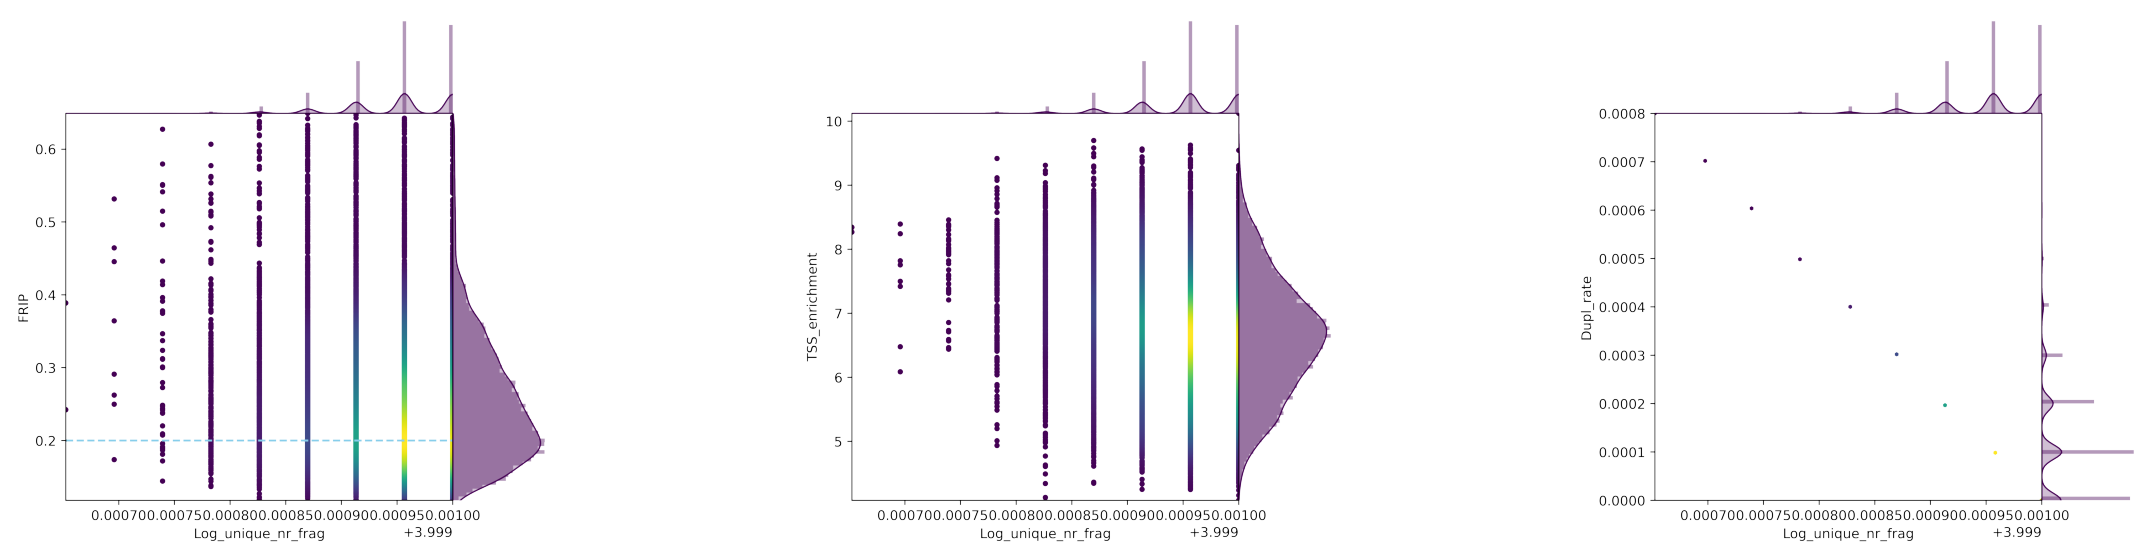

In [31]:
# Plot barcode stats in one figure
fig=plt.figure(figsize=(40,10))
plt.subplot(1, 3, 1)
img = fig2img(FRIP_NR_FRAG_fig) #To convert figures to png to plot together, see .utils.py. This converts the figure to png.
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 2)
img = fig2img(TSS_NR_FRAG_fig)
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 3)
img = fig2img(DR_NR_FRAG_fig)
plt.imshow(img)
plt.axis('off')
plt.show()

## 2. Create cisTopic object

In [32]:
# Path to regions
path_to_regions = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/DPCL/data/MACS_ATAC/iterative/peak_filtering_norm/combined_summits_final.bed'
# Blacklist
path_to_blacklist = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/pycisTopic/blacklist/hg38-blacklist.v2.bed'
# Metrics
import pickle
infile = open(outDir + 'quality_control/metadata_bc.pkl', 'rb')
metadata_bc = pickle.load(infile)
infile.close()
#Create objects
from pycisTopic.cistopic_class import *
cistopic_obj_list=[create_cistopic_object_from_fragments(path_to_fragments=fragments_dict[key],
                                               path_to_regions=path_to_regions,
                                               path_to_blacklist=path_to_blacklist,
                                               metrics=metadata_bc[key],
                                               valid_bc=None,
                                               n_cpu=1,
                                               project=key) for key in fragments_dict.keys()]

2022-11-07 16:35:56,852 cisTopic     INFO     Reading data for DPLC
2022-11-07 16:37:23,550 cisTopic     INFO     metrics provided!
2022-11-07 16:37:36,406 cisTopic     INFO     Counting fragments in regions
2022-11-07 16:40:01,573 cisTopic     INFO     Creating fragment matrix


/opt/venv/lib/python3.8/site-packages/pandas/core/reshape/reshape.py:134: PerformanceWarning: The following operation may generate 16074525000 cells in the resulting pandas object.
  warnings.warn(


2022-11-07 16:54:08,331 cisTopic     INFO     Converting fragment matrix to sparse matrix
2022-11-07 17:01:12,192 cisTopic     INFO     Removing blacklisted regions
2022-11-07 17:01:15,456 cisTopic     INFO     Creating CistopicObject
2022-11-07 17:01:21,380 cisTopic     INFO     Done!


In [33]:
cistopic_obj = cistopic_obj_list[0]
print(cistopic_obj)

CistopicObject from project DPLC with n_cells × n_regions = 25000 × 642981


In [34]:
# Save
with open(outDir + 'DPCL_cisTopicObject_10K_fragments_25K_cells.pkl', 'wb') as f:
  pickle.dump(cistopic_obj, f)

In [35]:
cell_names = [y + '_' + str(x) for y in ['GM12878', 'HCT116', 'HepG2', 'IMR90', 'K562', 'MCF7', 'PC3', 'Panc1'] for x in range(1,1251)]
len(cell_names)

10000

In [36]:
cistopic_obj.subset(cells=cell_names)

In [37]:
print(cistopic_obj)

CistopicObject from project DPLC with n_cells × n_regions = 10000 × 642971


In [38]:
# Save
with open(outDir + 'DPCL_cisTopicObject_10K_fragments_10K_cells.pkl', 'wb') as f:
  pickle.dump(cistopic_obj, f)

In [39]:
cell_names = [y + '_' + str(x) for y in ['GM12878', 'HCT116', 'HepG2', 'IMR90', 'K562', 'MCF7', 'PC3', 'Panc1'] for x in range(1,126)]
len(cell_names)
cistopic_obj.subset(cells=cell_names)
print(cistopic_obj)

CistopicObject from project DPLC with n_cells × n_regions = 1000 × 597837


In [40]:
# Save
with open(outDir + 'DPCL_cisTopicObject_10K_fragments_1K_cells.pkl', 'wb') as f:
  pickle.dump(cistopic_obj, f)

In [41]:
cell_names = [y + '_' + str(x) for y in ['GM12878', 'HCT116', 'HepG2', 'IMR90', 'K562', 'MCF7', 'PC3', 'Panc1'] for x in range(1,11)]
len(cell_names)
cistopic_obj.subset(cells=cell_names)
print(cistopic_obj)

CistopicObject from project DPLC with n_cells × n_regions = 80 × 209805


In [42]:
# Save
with open(outDir + 'DPCL_cisTopicObject_10K_fragments_80_cells.pkl', 'wb') as f:
  pickle.dump(cistopic_obj, f)

# 3. High

## 0. Set paths

In [43]:
# Variables
## Outdir
outDir = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/DPCL/speed_benchmark/high_simulation/'
import os
if not os.path.exists(outDir):
    os.makedirs(outDir)
## Temp
tmpDir = '/scratch/leuven/313/vsc31305/'
## Path to fragments
fragments_dict = {'DPLC': '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/DPCL/speed_benchmark/data/high/atac/fragments.tsv'}

## 1. QC

In [44]:
# Get TSS annotations
import pybiomart as pbm
# For mouse (mm39)
#dataset = pbm.Dataset(name='mmusculus_gene_ensembl',  host='http://www.ensembl.org')
# For mouse (mm10)
#dataset = pbm.Dataset(name='mmusculus_gene_ensembl',  host='http://nov2020.archive.ensembl.org/')
# For human (hg38)
dataset = pbm.Dataset(name='hsapiens_gene_ensembl',  host='http://www.ensembl.org')
# For human (hg19)
#dataset = pbm.Dataset(name='hsapiens_gene_ensembl',  host='http://grch37.ensembl.org/')
# For fly (dm6)
# dataset = pbm.Dataset(name='dmelanogaster_gene_ensembl',  host='http://www.ensembl.org')
annot = dataset.query(attributes=['chromosome_name', 'transcription_start_site', 'strand', 'external_gene_name', 'transcript_biotype'])
annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].astype('str')
filter = annot['Chromosome/scaffold name'].str.contains('CHR|GL|JH|MT')
annot = annot[~filter]
annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].str.replace(r'(\b\S)', r'chr\1')
annot.columns=['Chromosome', 'Start', 'Strand', 'Gene', 'Transcript_type']
annot = annot[annot.Transcript_type == 'protein_coding']

/local_scratch/tmp-vsc31305/ipykernel_29089/2601143857.py:17: FutureWarning: The default value of regex will change from True to False in a future version.
  annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].str.replace(r'(\b\S)', r'chr\1')


In [45]:
from pycisTopic.qc import *
path_to_regions = {'DPLC':'/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/DPCL/data/MACS_ATAC/iterative/peak_filtering_norm/combined_summits_final.bed'}
metadata_bc, profile_data_dict = compute_qc_stats(fragments_dict = fragments_dict,
                tss_annotation = annot,
                stats=['barcode_rank_plot', 'duplicate_rate', 'insert_size_distribution', 'profile_tss', 'frip'],
                label_list = None,
                path_to_regions = path_to_regions,
                n_cpu = 1,
                valid_bc = None,
                n_frag = 100,
                n_bc = None,
                tss_flank_window = 1000,
                tss_window = 50,
                tss_minimum_signal_window = 100,
                tss_rolling_window = 10,
                remove_duplicates = True,
                _temp_dir = tmpDir + 'ray_spill')

2022-11-07 17:10:40,602 cisTopic     INFO     Reading DPLC
2022-11-07 17:14:50,120 cisTopic     INFO     Computing barcode rank plot for DPLC
2022-11-07 17:14:50,124 cisTopic     INFO     Counting fragments
2022-11-07 17:15:05,603 cisTopic     INFO     Marking barcodes with more than 100
2022-11-07 17:15:05,613 cisTopic     INFO     Returning plot data
2022-11-07 17:15:05,615 cisTopic     INFO     Returning valid barcodes
2022-11-07 17:15:31,856 cisTopic     INFO     Computing duplicate rate plot for DPLC
2022-11-07 17:15:52,289 cisTopic     INFO     Return plot data
2022-11-07 17:15:52,726 cisTopic     INFO     Computing insert size distribution for DPLC
2022-11-07 17:15:52,727 cisTopic     INFO     Counting fragments
2022-11-07 17:16:04,873 cisTopic     INFO     Returning plot data
2022-11-07 17:21:04,025 cisTopic     INFO     Computing TSS profile for DPLC
2022-11-07 17:21:23,261 cisTopic     INFO     Formatting annnotation
2022-11-07 17:21:23,332 cisTopic     INFO     Creating cove

In [46]:
os.makedirs(outDir+'quality_control')
import pickle 
with open(outDir + 'quality_control/metadata_bc.pkl', 'wb') as f:
  pickle.dump(metadata_bc, f)

In [47]:
import pickle 
with open(outDir + 'quality_control/profile_data_dict.pkl', 'wb') as f:
  pickle.dump(profile_data_dict, f)

/opt/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


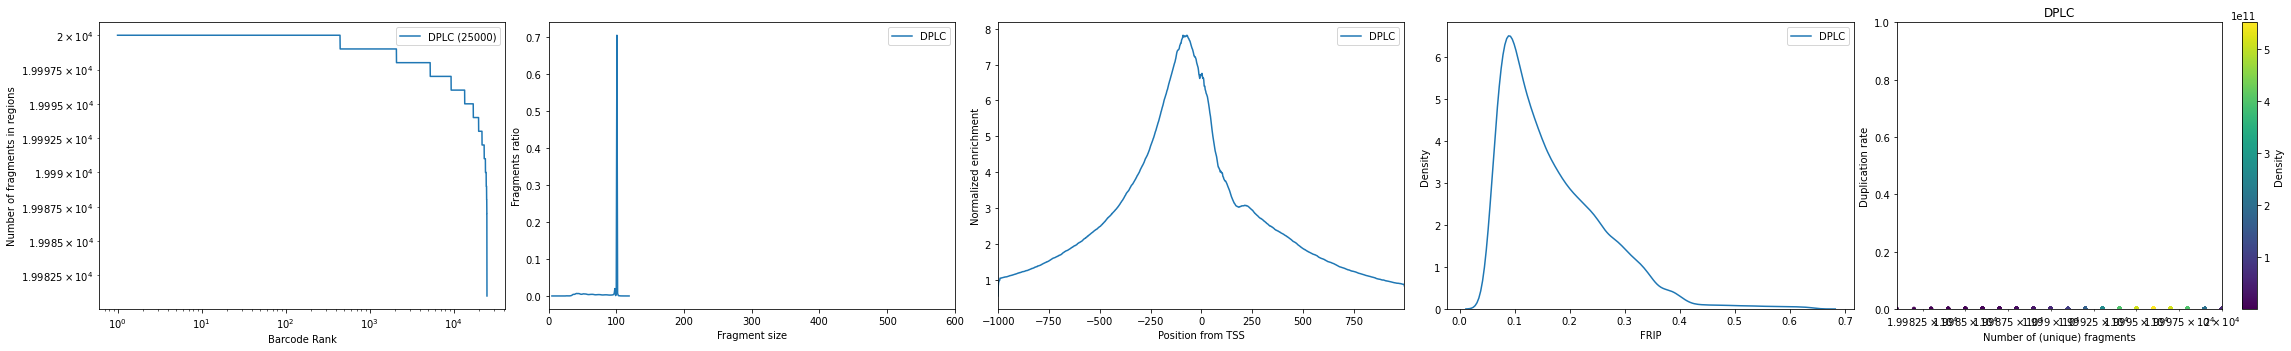

In [48]:
from pycisTopic.qc import *
plot_sample_metrics(profile_data_dict,
           insert_size_distriubtion_xlim=[0,600],
           ncol=5,
           plot=True,
           save= outDir + 'quality_control/sample_metrics.pdf')

In [49]:
# Return figure to plot together with other metrics, and cells passing filters. Figure will be saved as pdf.
from pycisTopic.qc import *
FRIP_NR_FRAG_fig, FRIP_NR_FRAG_filter=plot_barcode_metrics(metadata_bc['DPLC'],
                                       var_x='Log_unique_nr_frag',
                                       var_y='FRIP',
                                       min_x=3.5,
                                       max_x=None,
                                       min_y=0.2,
                                       max_y=None,
                                       return_cells=True,
                                       return_fig=True,
                                       plot=False,
                                       save= outDir + 'quality_control/barcode_metrics_FRIP-VS-NRFRAG.pdf')
# Return figure to plot together with other metrics, and cells passing filters
TSS_NR_FRAG_fig, TSS_NR_FRAG_filter=plot_barcode_metrics(metadata_bc['DPLC'],
                                      var_x='Log_unique_nr_frag',
                                      var_y='TSS_enrichment',
                                      min_x=3.5,
                                      max_x=None,
                                      min_y=4,
                                      max_y=None,
                                      return_cells=True,
                                      return_fig=True,
                                      plot=False,
                                      save= outDir + 'quality_control/barcode_metrics_TSS-VS-NRFRAG.pdf')
# Return figure to plot together with other metrics, but not returning cells (no filter applied for the duplication rate  per barcode)
DR_NR_FRAG_fig=plot_barcode_metrics(metadata_bc['DPLC'],
                                      var_x='Log_unique_nr_frag',
                                      var_y='Dupl_rate',
                                      min_x=3.5,
                                      max_x=None,
                                      min_y=None,
                                      max_y=None,
                                      return_cells=False,
                                      return_fig=True,
                                      plot=False,
                                      plot_as_hexbin = True)

/opt/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/venv/lib/python3.8/site-packages/seaborn/distributions.py:1689: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)
/opt/venv/lib/python3.8/site-packages/seaborn/distribut

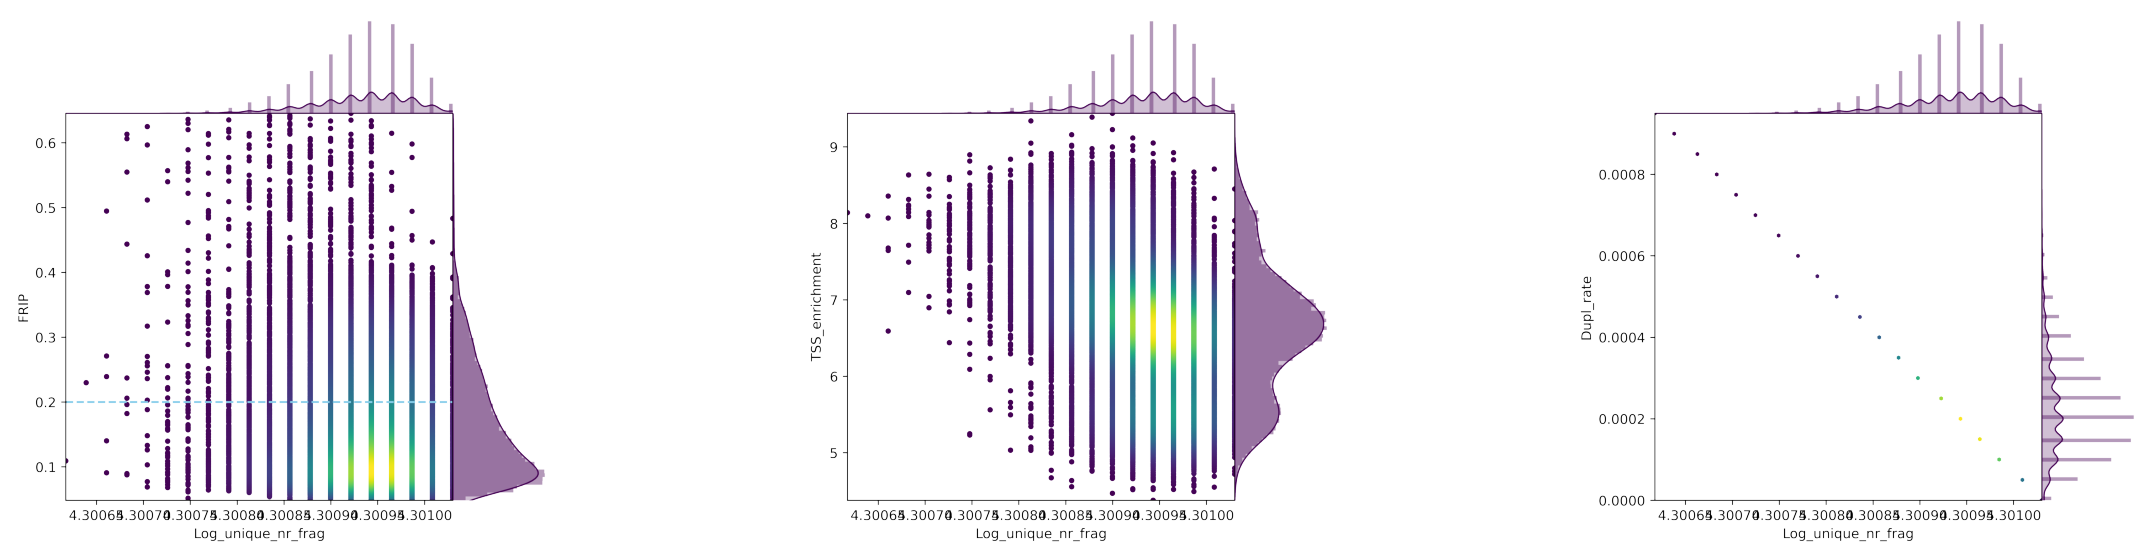

In [50]:
# Plot barcode stats in one figure
fig=plt.figure(figsize=(40,10))
plt.subplot(1, 3, 1)
img = fig2img(FRIP_NR_FRAG_fig) #To convert figures to png to plot together, see .utils.py. This converts the figure to png.
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 2)
img = fig2img(TSS_NR_FRAG_fig)
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 3)
img = fig2img(DR_NR_FRAG_fig)
plt.imshow(img)
plt.axis('off')
plt.show()

## 2. Create cisTopic object

In [51]:
# Path to regions
path_to_regions = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/DPCL/data/MACS_ATAC/iterative/peak_filtering_norm/combined_summits_final.bed'
# Blacklist
path_to_blacklist = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/pycisTopic/blacklist/hg38-blacklist.v2.bed'
# Metrics
import pickle
infile = open(outDir + 'quality_control/metadata_bc.pkl', 'rb')
metadata_bc = pickle.load(infile)
infile.close()
#Create objects
from pycisTopic.cistopic_class import *
cistopic_obj_list=[create_cistopic_object_from_fragments(path_to_fragments=fragments_dict[key],
                                               path_to_regions=path_to_regions,
                                               path_to_blacklist=path_to_blacklist,
                                               metrics=metadata_bc[key],
                                               valid_bc=None,
                                               n_cpu=1,
                                               project=key) for key in fragments_dict.keys()]

2022-11-07 17:37:07,739 cisTopic     INFO     Reading data for DPLC
2022-11-07 17:40:07,467 cisTopic     INFO     metrics provided!
2022-11-07 17:40:37,706 cisTopic     INFO     Counting fragments in regions
2022-11-07 17:45:25,576 cisTopic     INFO     Creating fragment matrix


/opt/venv/lib/python3.8/site-packages/pandas/core/reshape/reshape.py:134: PerformanceWarning: The following operation may generate 16074550000 cells in the resulting pandas object.
  warnings.warn(


2022-11-07 18:05:01,226 cisTopic     INFO     Converting fragment matrix to sparse matrix
2022-11-07 18:13:08,425 cisTopic     INFO     Removing blacklisted regions
2022-11-07 18:13:12,460 cisTopic     INFO     Creating CistopicObject
2022-11-07 18:13:22,376 cisTopic     INFO     Done!


In [52]:
cistopic_obj = cistopic_obj_list[0]
print(cistopic_obj)

CistopicObject from project DPLC with n_cells × n_regions = 25000 × 642982


In [53]:
# Save
with open(outDir + 'DPCL_cisTopicObject_20K_fragments_25K_cells.pkl', 'wb') as f:
  pickle.dump(cistopic_obj, f)

In [54]:
cell_names = [y + '_' + str(x) for y in ['GM12878', 'HCT116', 'HepG2', 'IMR90', 'K562', 'MCF7', 'PC3', 'Panc1'] for x in range(1,1251)]
len(cell_names)

10000

In [55]:
cistopic_obj.subset(cells=cell_names)

In [56]:
print(cistopic_obj)

CistopicObject from project DPLC with n_cells × n_regions = 10000 × 642982


In [57]:
# Save
with open(outDir + 'DPCL_cisTopicObject_20K_fragments_10K_cells.pkl', 'wb') as f:
  pickle.dump(cistopic_obj, f)

In [58]:
cell_names = [y + '_' + str(x) for y in ['GM12878', 'HCT116', 'HepG2', 'IMR90', 'K562', 'MCF7', 'PC3', 'Panc1'] for x in range(1,126)]
len(cell_names)
cistopic_obj.subset(cells=cell_names)
print(cistopic_obj)

CistopicObject from project DPLC with n_cells × n_regions = 1000 × 634436


In [59]:
# Save
with open(outDir + 'DPCL_cisTopicObject_20K_fragments_1K_cells.pkl', 'wb') as f:
  pickle.dump(cistopic_obj, f)

In [60]:
cell_names = [y + '_' + str(x) for y in ['GM12878', 'HCT116', 'HepG2', 'IMR90', 'K562', 'MCF7', 'PC3', 'Panc1'] for x in range(1,11)]
len(cell_names)
cistopic_obj.subset(cells=cell_names)
print(cistopic_obj)

CistopicObject from project DPLC with n_cells × n_regions = 80 × 316504


In [61]:
# Save
with open(outDir + 'DPCL_cisTopicObject_20K_fragments_80_cells.pkl', 'wb') as f:
  pickle.dump(cistopic_obj, f)

In [62]:
print(cistopic_obj)

CistopicObject from project DPLC with n_cells × n_regions = 80 × 316504
